In [1]:
import pandas as pd
import nltk as nltk
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
import timeit
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import decomposition
from sklearn.preprocessing import MinMaxScaler
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 200)


In [2]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)


Navigation vers le dossier source

In [6]:
cd ../P5_suggestion_de_tag

/Users/jfv/Desktop/Formation_Ingenieur_Machine_Learning/P5_voelker_jean-florent/P5_suggestion_de_tag


Chargement des données d'entrée

In [7]:
question_df = pd.read_csv("df_question_cleaned.csv", delimiter=",")
question_df = question_df.drop('Unnamed: 0', axis=1)

question_columns = question_df.columns

In [ ]:
tags_df = pd.read_csv("df_tags_cleaned.csv", delimiter=",")
tags_df = tags_df.drop('Unnamed: 0', axis=1)

tags_columns = tags_df.columns
tags_df = pd.DataFrame(tags_df.values)

# Séparation des données en train_dataset et test_dataset

In [242]:
X_train, y_train, X_test, y_test = iterative_train_test_split(np.array(question_df), np.array(tags_df), test_size = 0.25)

# Entrainement des Classifieurs

#### Import des méthodes de classification multiclass qui permettent d'utiliser des estimateurs binaires

In [243]:
from sklearn.multiclass import OneVsRestClassifier

#### Import des estimateurs binaires ou linéaires

In [244]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [316]:
estimators = {
    "LogisticRegression": LogisticRegression(),
    "SVC": SVC(),
    "GaussianNB": GaussianNB(),
    "DummyClassifier": DummyClassifier(),
}

estimators_list=["LogisticRegression","SVC","GaussianNB","DummyClassifier"]

#### Définition des paramètres d'optimization

In [317]:
param_grid ={
    "LogisticRegression": {
        "estimator__C": np.logspace(-3,3,7),
        "estimator__penalty": ["l2"],
        "estimator__solver": ["newton-cg", "lbfgs", "sag"],
        "estimator__max_iter": [10000]
    },
    "LogisticRegression": {
        "estimator__C": np.logspace(-3,3,7),
        "estimator__penalty": ["l2","l1"],
        "estimator__solver": ["liblinear","saga"],
        "estimator__max_iter": [10000]
    },
    "SVC": {
        "estimator__kernel": ["linear", "poly", "rbf"] ,
        "estimator__gamma": ["scale", "auto"],
        "estimator__C": np.logspace(-1,3,5)
    },
    "GaussianNB": {
        "estimator__var_smoothing": np.logspace(0,-9, num=20)
    },
    "DummyClassifier":{
        "estimator__strategy":["stratified"],
        "estimator__random_state":[0]
    }
}


#### Import des méthodes de scoring

In [318]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 

#### Classification selon la méthode OneVsRestClassifier

J'effectue une classification sur un

Je recherche le meilleur tuning pour chaque estimator que fitte sur les données d'entrainement.

In [319]:
OneVsRestClassifier_fitted_model={}

for estimator in estimators_list:
    print('Fitting of '+estimator)
    
    start_time = timeit.default_timer()
    model_to_set = OneVsRestClassifier(estimators[estimator])
    
    clf = GridSearchCV(
        model_to_set,
        param_grid[estimator],
        n_jobs=-1,
        scoring="accuracy",
        cv=5
    )

    OneVsRestClassifier_fitted_model[estimator]=clf.fit(X_train, y_train)
    
    end_time = timeit.default_timer()
    elapsed = end_time - start_time
    
    print("{} model fitted, time {:.2f}s".format(estimator, elapsed))
    print("Voici les meilleurs paramètres du modèle :")
    print(clf.best_params_)
    

Fitting of LogisticRegression
LogisticRegression model fitted, time 10803.23s
Voici les meilleurs paramètres du modèle :
{'estimator__C': 10.0, 'estimator__max_iter': 10000, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}
Fitting of SVC
SVC model fitted, time 8336.91s
Voici les meilleurs paramètres du modèle :
{'estimator__C': 1000.0, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf'}
Fitting of GaussianNB
GaussianNB model fitted, time 139.10s
Voici les meilleurs paramètres du modèle :
{'estimator__var_smoothing': 1.0}
Fitting of DummyClassifier
DummyClassifier model fitted, time 0.33s
Voici les meilleurs paramètres du modèle :
{'estimator__random_state': 0, 'estimator__strategy': 'stratified'}


/Users/jfv/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)


In [320]:
Classifier_result=[]

for estimator in estimators_list:
    
    #prédiction des classifications
    y_predicted=OneVsRestClassifier_fitted_model[estimator].predict(X_test)

    #calcul des scores de prédiction
    accuracy_scoring=accuracy_score(y_true=y_test,y_pred=y_predicted)
    F1_averaged_score=f1_score(y_true=y_test, y_pred=y_predicted,average='weighted', zero_division=1)
    auc = roc_auc_score(y_test, y_predicted)
    
    Classifier_result.append(['OneVsRest',estimator,'Accuracy score',accuracy_scoring])
    Classifier_result.append(['OneVsRest',estimator,'F1 averaged score',F1_averaged_score])
    Classifier_result.append(['OneVsRest',estimator,'ROC AUC Score',auc])

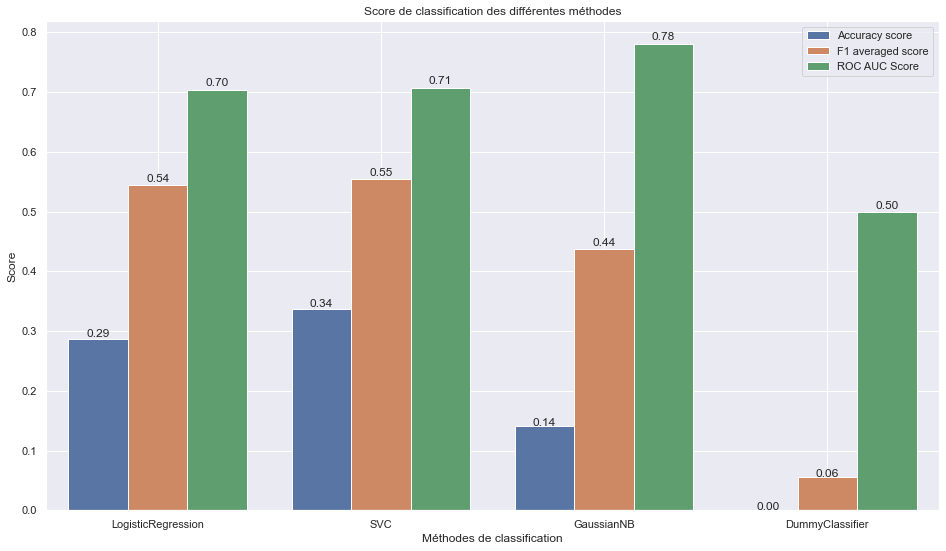

In [321]:
scores_df = pd.DataFrame(Classifier_result)

barWidth = 0.25
plt.figure(figsize=(16, 9))
sns.set(style='dark')
p=sns.barplot(x=1, y=3, hue=2, data=scores_df)
show_values(p)
plt.xlabel("Méthodes de classification")
plt.ylabel("Score")
plt.title("Score de classification des différentes méthodes")
plt.grid(True)
plt.legend()
plt.show()

# Création du pipeline de prédiction

J'encapsule les étapes de prétraitement dans un Custom Transformer:

In [322]:
class PreprocessingDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        CleanedData=[]
        
        for body in X:
            new_text=body_to_words(body[0])
            CleanedData.append(new_text)
        
        return CleanedData

    
def body_to_words(raw_text):
    # 1. Retirer les balises HTML
    review_text = BeautifulSoup(raw_text,"html.parser").get_text() 
    #
    # 2. Retirer les caractères non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. convertir les lettres en minuscules, split into individual words
    words = letters_only.lower().split()                              


    # 4. Création d'un set de stopwords
    stops = set(stopwords.words("english"))        

    # 5. Retirer les stopwords du body
    words = [w for w in words if not w in stops]   

    # 6. Retirer les répétitions de lettres type : "aaa", "bbbbbbb", etc...
    words = [w for w in words if bool(re.search(r"(.)\1+",w))==False]


    #J'initialise un lemminizer celui-ci va plus loin qu'un stemmer en effectuant un contextualisation
    lemmatizer = WordNetLemmatizer()

    # loop for stemming each word
    # in string array at ith row   
    meaningful_words = [lemmatizer.lemmatize(word) for word in words]

    # 6. Jointure de tous les mots conservés et retour du résultat 
    return( " ".join(meaningful_words))   


In [323]:
class DensifierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.toarray()
        #return self

In [324]:
ClassifierBestParams = OneVsRestClassifier_fitted_model["SVC"].best_params_

In [335]:
n_comp = question_df.shape[1]

In [336]:
pipeline = Pipeline(
    steps=[
        ('PreprocessingDataTransformer',PreprocessingDataTransformer()),
        ('tfidf_vectorizer', TfidfVectorizer(min_df=0.001,max_df=0.75,  ngram_range=(1, 1))),
        ('densifierTransformer',DensifierTransformer()),
        ('pca', decomposition.PCA(n_components=n_comp)),
        ('clf',
           OneVsRestClassifier(SVC(
                C=ClassifierBestParams['estimator__C'],
                kernel=ClassifierBestParams['estimator__kernel'],
                gamma=ClassifierBestParams['estimator__gamma'],
            )
           )                   
        )
    ]
)

J'importe les données brutes

In [337]:
RawDataset = pd.read_csv("QueryResults.csv", delimiter=",")
RawDataset_array=RawDataset.dropna()

In [338]:
RawDataset_array=RawDataset_array.iloc[:5000,:]

In [339]:
RawDataset_array_2=RawDataset_array['Title']+RawDataset_array['Body']

In [340]:
RawDataset_array_2=pd.DataFrame(RawDataset_array_2)

J'entraine mon pipeline sur les données complètes:

In [341]:
start_time = timeit.default_timer()

pipeline.fit(np.array(RawDataset_array_2), np.array(tags_df))

end_time = timeit.default_timer()
elapsed = end_time - start_time

print("Pipeline fitted, time {:.2f}s".format(elapsed))

Pipeline fitted, time 50.80s


Je serialise mon pipeline (stockage numérique d'un objet):

In [342]:
import joblib

In [378]:
joblib.dump(pipeline, '../tagging_api/tagging_classifieur.joblib')

['../tagging_api/tagging_classifieur.joblib']

Je serialise la liste des tags retenus:

In [347]:
joblib.dump(tags_columns, '../tagging_api/liste_tags_retenus.joblib')

['../tagging_api/liste_tags_retenus.joblib']

#### Classification selon la méthode LatentDirichletAllocation

Je chargeles données d'entrée nettoyées sans PCA, ce qui permettra d'interpréter le résultat de la LDA

In [8]:
question_lda_df = pd.read_csv("df_question_cleaned_without_pca.csv", delimiter=",")
question_lda_df = question_lda_df.drop('Unnamed: 0', axis=1)

Je sépare le jeu de données entre train et test-dataset/

In [9]:
X_train_lda, X_test_lda= train_test_split(question_lda_df, test_size=0.25, random_state=42)

J'entraine sur X_train_positive_scaling et optimize un modèle LatentDirichletAllocation

In [12]:
# Define Search Param
search_params = {
    'n_components': [4, 5, 6, 7, 8, 9, 10,11,12,13,14,15, 20, 25, 30], 
    'learning_decay': [.5, .7, .9]
}

# Init the Model
lda = decomposition.LatentDirichletAllocation(
        max_iter=10, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, cv=5)

# Enregistrement de l'heure de début
start_time = timeit.default_timer()

# Do the Grid Search
lda_fitted=model.fit(X_train_lda)

# enregistrement de l'heure de fin et calcul de la durée
end_time = timeit.default_timer()
elapsed = end_time - start_time

print("Pipeline fitted, time {:.2f}s".format(elapsed))


Pipeline fitted, time 769.69s


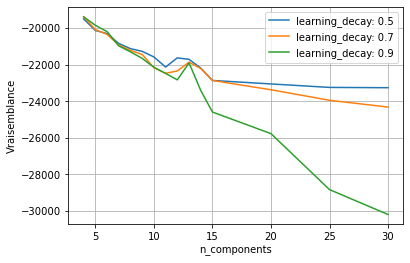

In [13]:
mean_score=lda_fitted.cv_results_["mean_test_score"]
taille_serie = len(search_params["n_components"])

i=0
for learning_decay in search_params["learning_decay"]:
    plt.plot(search_params["n_components"], mean_score[i*taille_serie:(i+1)*taille_serie], label='learning_decay: ' + str(learning_decay))
    i+=1
    
plt.legend()
plt.xlabel('n_components')
plt.ylabel('Vraisemblance')
plt.grid(True)
plt.show()

Je choisis la configuration avec 10 thèmes et un learning_decay de 0.5

Je récupère le meilleur estimateur entraîné

In [561]:
lda_model = decomposition.LatentDirichletAllocation(
        max_iter=10, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0,
        n_components=10, 
        learning_decay=.5
)

lda_fitted=lda_model.fit(X_train_lda)

J'affiche les mots les plus représentatifs des sujets modélisés

In [562]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 6
display_topics(lda_model, question_lda_df.columns, no_top_words)

Topic 0:
git android px layout branch height
Topic 1:
url json php server request data
Topic 2:
file window directory path script project
Topic 3:
string value list like way function
Topic 4:
ruby font li ul weight navbar
Topic 5:
div image html jquery option text
Topic 6:
table sql column row database query
Topic 7:
eclipse studio visual proxy binding block
Topic 8:
java thread org play hibernate download
Topic 9:
regex extract numpy sum match regular
